Dataset shape: (429435, 67)

Columns in the dataset:
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hun

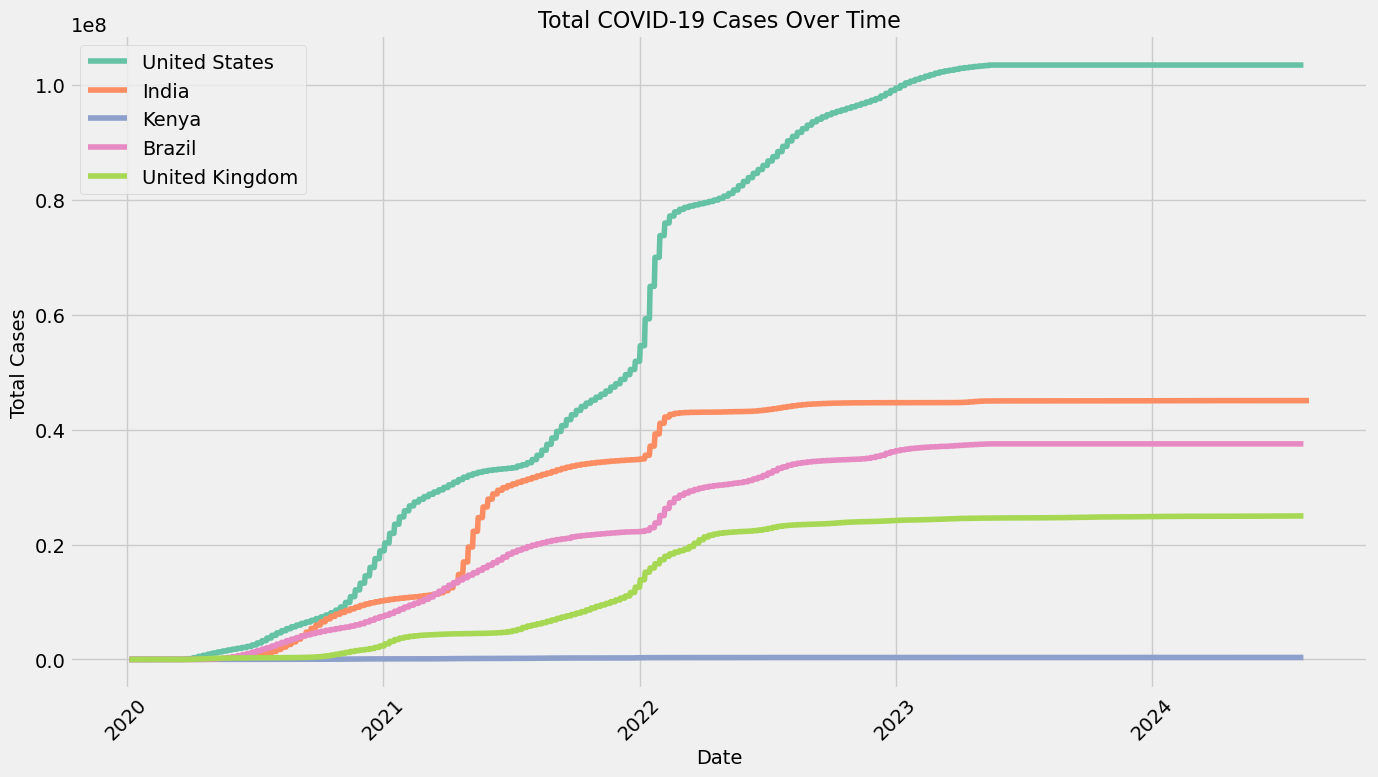

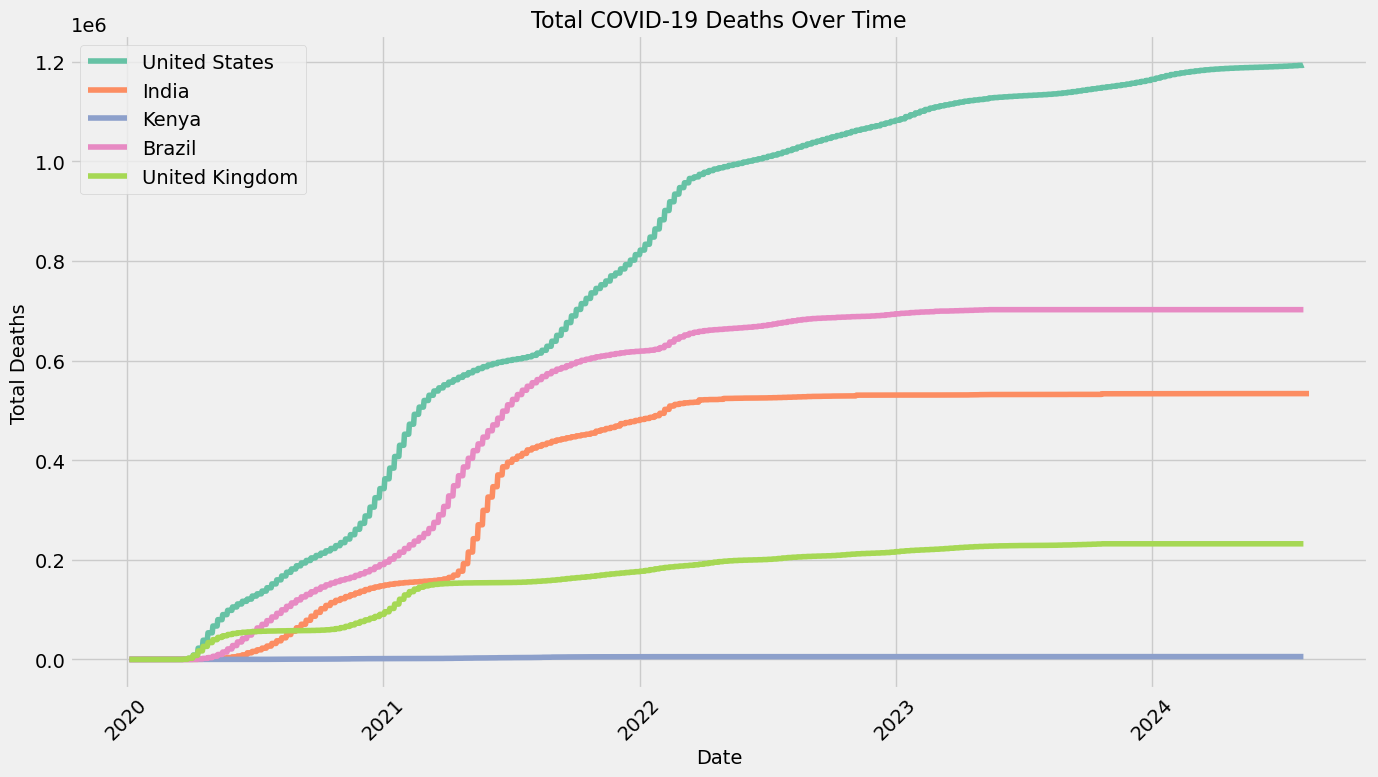

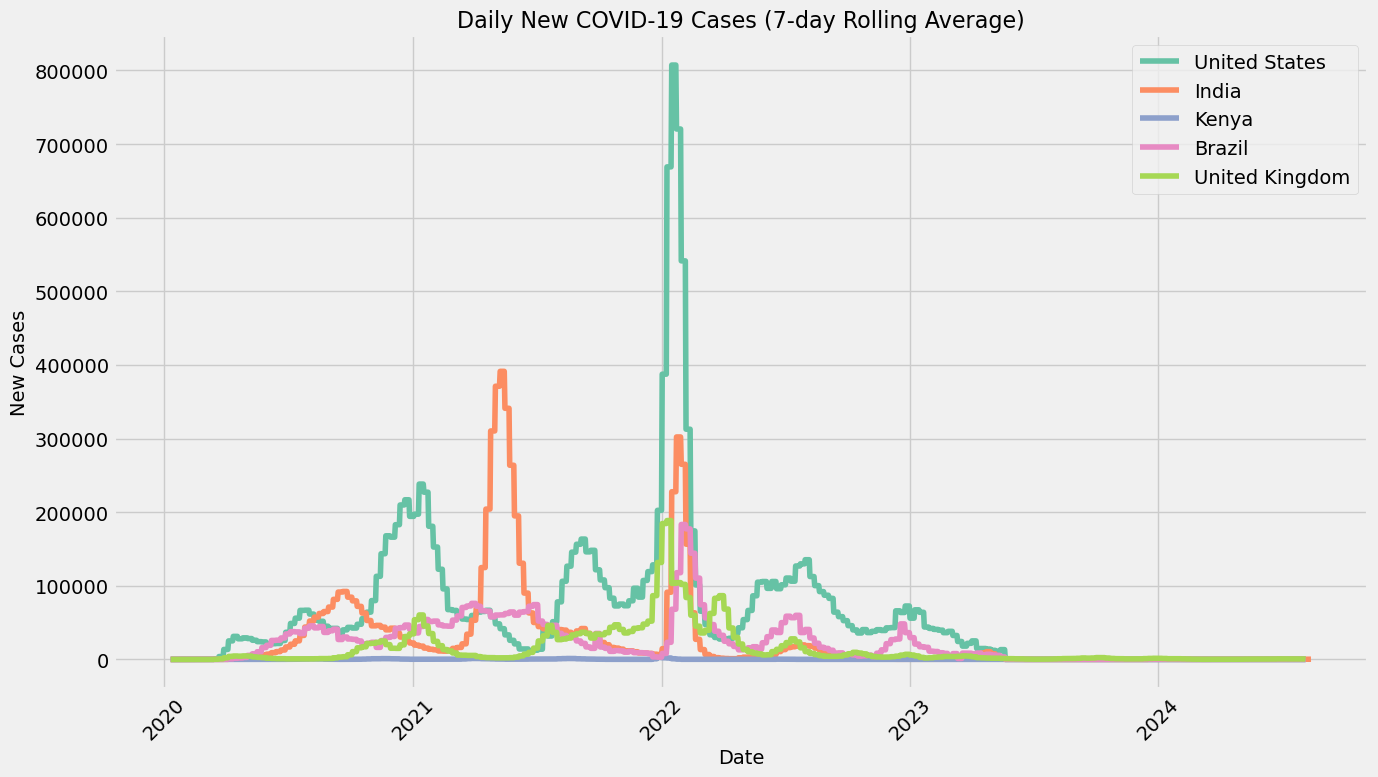

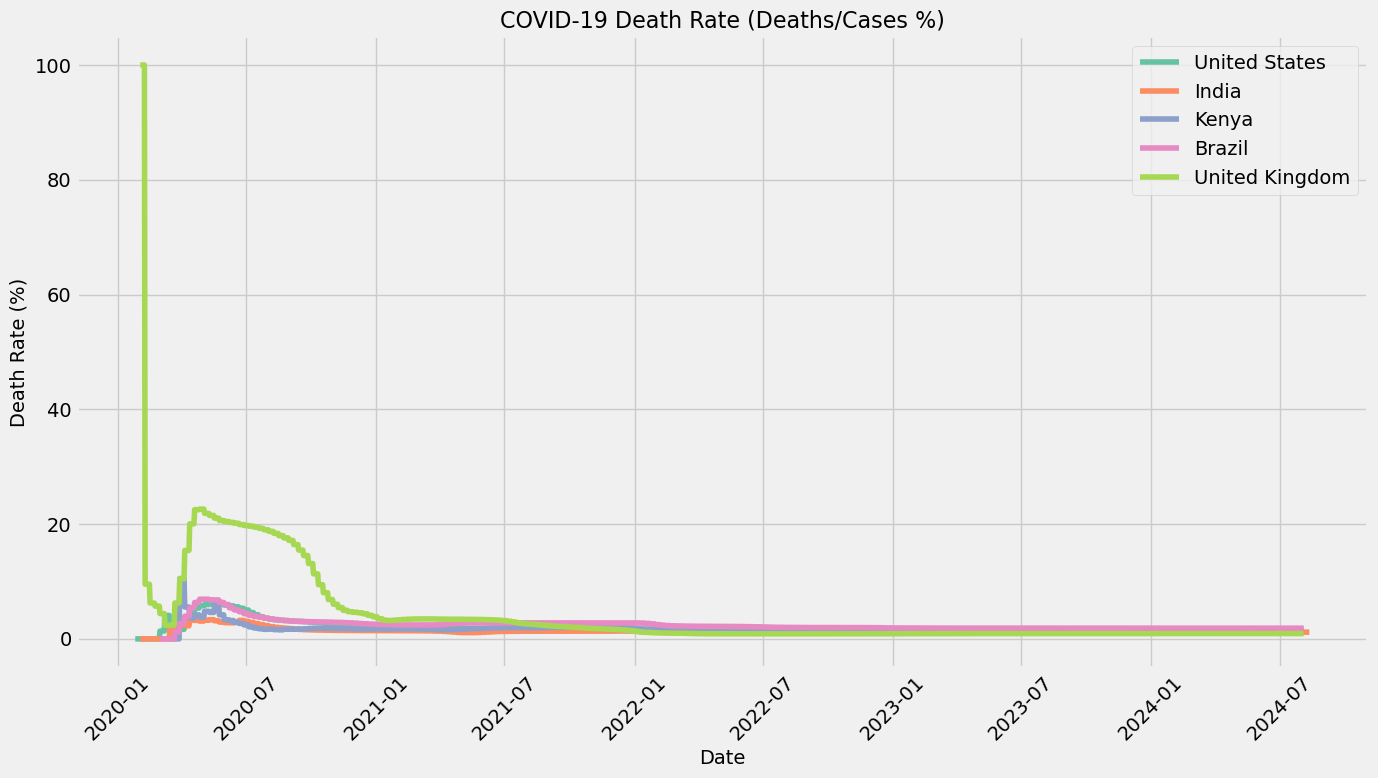

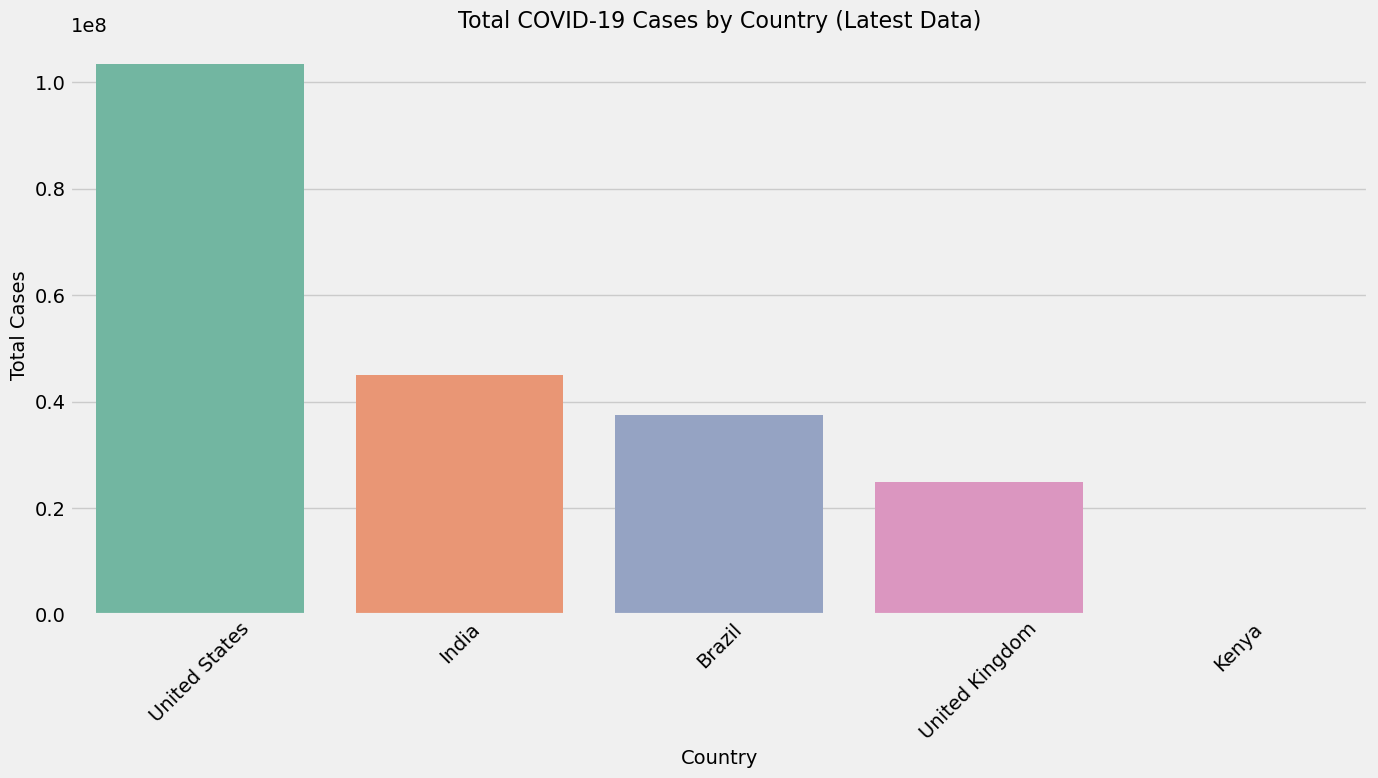

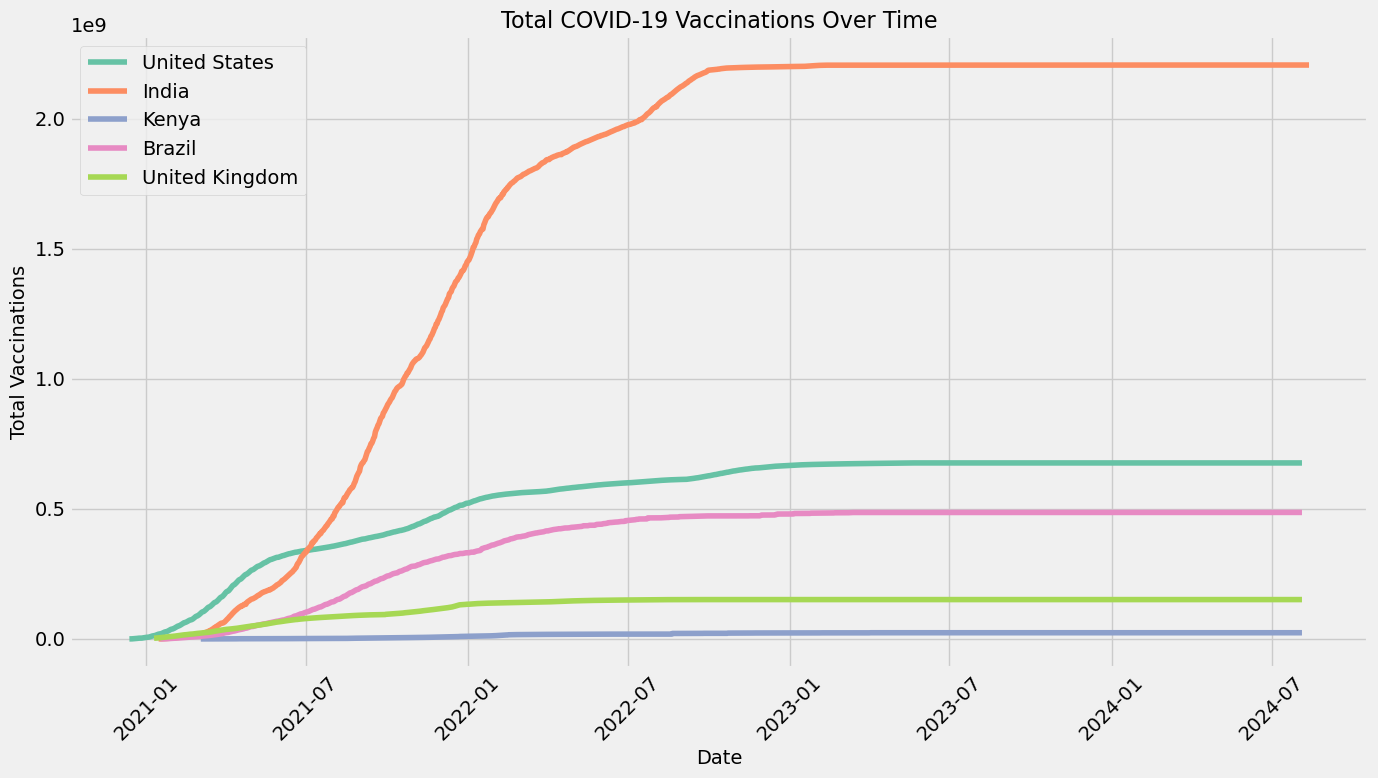

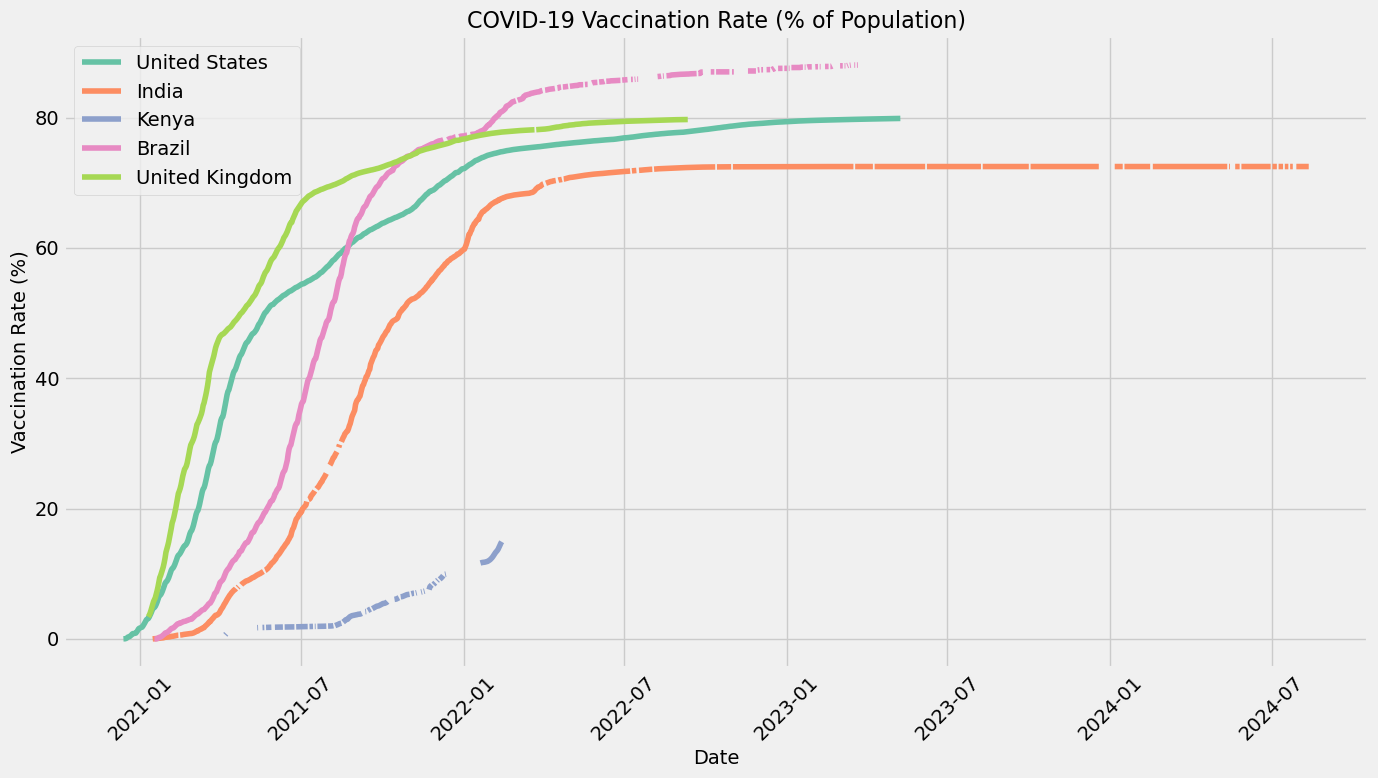

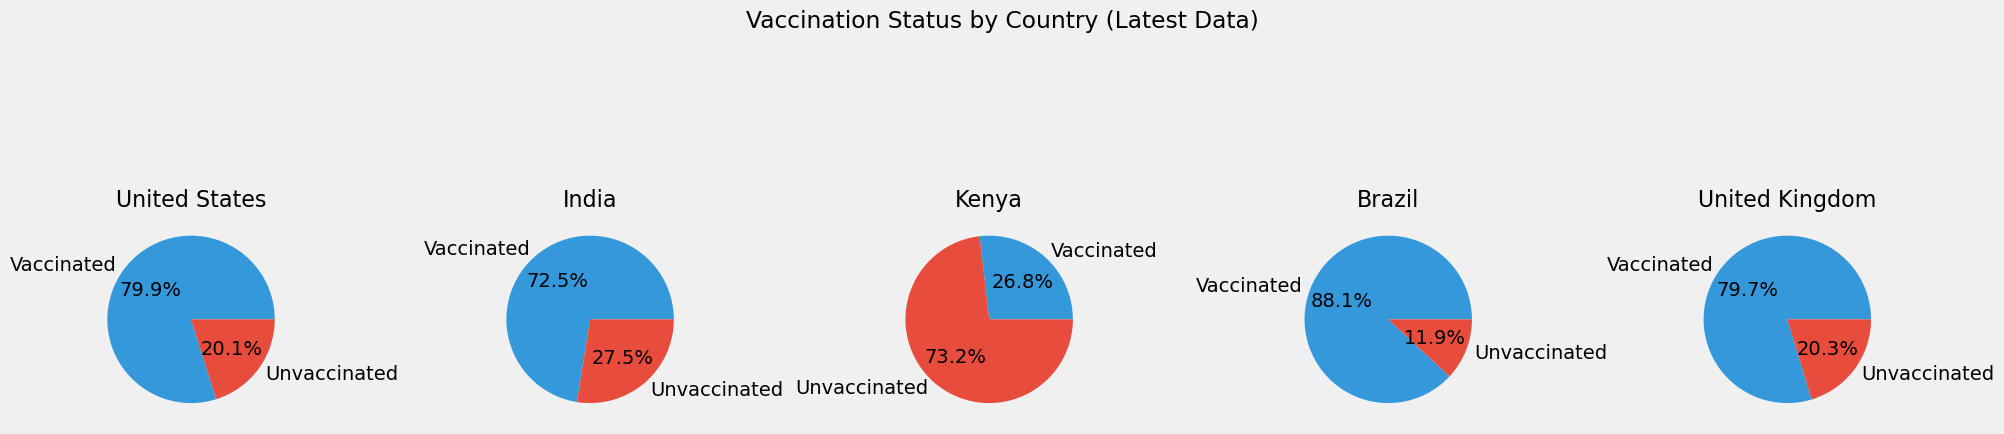

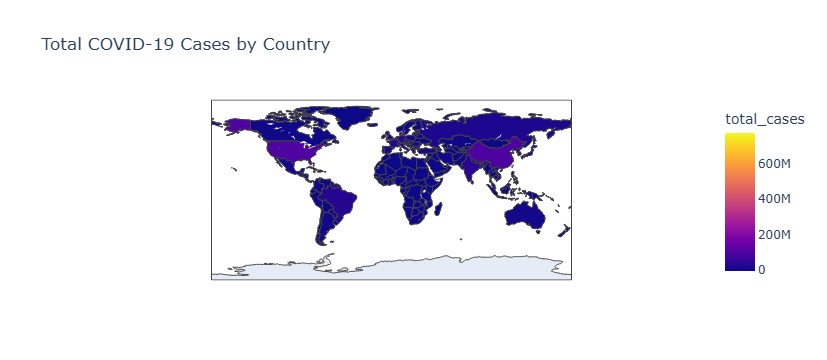

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# 1. Data Loading & Exploration
# Load the dataset
# Note: You'll need to update this path to where you've downloaded the dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"  # Alternative source if Kaggle download isn't working
df = pd.read_csv(url)

# Check basic information
print("Dataset shape:", df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Preview the data
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

# 2. Data Cleaning
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Select countries of interest
countries = ['United States', 'India', 'Kenya', 'Brazil', 'United Kingdom']
df_selected = df[df['location'].isin(countries)]

# Check data availability for selected countries
print("\nData points per country:")
print(df_selected['location'].value_counts())

# Handle missing values for key metrics
key_columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations']
for col in key_columns:
    if col in df_selected.columns:
        # Forward fill within each country group
        df_selected[col] = df_selected.groupby('location')[col].transform(
            lambda x: x.fillna(method='ffill')
        )

# 3. Exploratory Data Analysis (EDA)
# Create a figure for total cases over time
plt.figure()
for country in countries:
    country_data = df_selected[df_selected['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)
plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a figure for total deaths over time
plt.figure()
for country in countries:
    country_data = df_selected[df_selected['location'] == country]
    plt.plot(country_data['date'], country_data['total_deaths'], label=country)
plt.title('Total COVID-19 Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Daily new cases comparison (7-day rolling average for smoothing)
plt.figure()
for country in countries:
    country_data = df_selected[df_selected['location'] == country]
    plt.plot(country_data['date'], 
             country_data['new_cases'].rolling(window=7).mean(), 
             label=country)
plt.title('Daily New COVID-19 Cases (7-day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and plot death rate
df_selected['death_rate'] = (df_selected['total_deaths'] / df_selected['total_cases']) * 100

plt.figure()
for country in countries:
    country_data = df_selected[df_selected['location'] == country]
    plt.plot(country_data['date'], country_data['death_rate'], label=country)
plt.title('COVID-19 Death Rate (Deaths/Cases %)')
plt.xlabel('Date')
plt.ylabel('Death Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar chart of total cases by country (latest data)
latest_data = df_selected.groupby('location').last().reset_index()
plt.figure()
sns.barplot(x='location', y='total_cases', data=latest_data.sort_values('total_cases', ascending=False))
plt.title('Total COVID-19 Cases by Country (Latest Data)')
plt.xlabel('Country')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Vaccination Analysis
if 'total_vaccinations' in df_selected.columns:
    # Plot cumulative vaccinations
    plt.figure()
    for country in countries:
        country_data = df_selected[df_selected['location'] == country]
        plt.plot(country_data['date'], country_data['total_vaccinations'], label=country)
    plt.title('Total COVID-19 Vaccinations Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Vaccinations')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Vaccination percentage (if people_vaccinated and population columns exist)
    if 'people_vaccinated' in df_selected.columns and 'population' in df_selected.columns:
        df_selected['vaccination_rate'] = (df_selected['people_vaccinated'] / df_selected['population']) * 100
        
        plt.figure()
        for country in countries:
            country_data = df_selected[df_selected['location'] == country]
            plt.plot(country_data['date'], country_data['vaccination_rate'], label=country)
        plt.title('COVID-19 Vaccination Rate (% of Population)')
        plt.xlabel('Date')
        plt.ylabel('Vaccination Rate (%)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Pie charts for latest vaccination data
        latest_vax_data = df_selected.groupby('location').last().reset_index()
        
        fig, axes = plt.subplots(1, len(countries), figsize=(20, 6))
        for i, country in enumerate(countries):
            country_row = latest_vax_data[latest_vax_data['location'] == country]
            if not country_row.empty and not pd.isna(country_row['vaccination_rate'].values[0]):
                vax_rate = country_row['vaccination_rate'].values[0]
                axes[i].pie([vax_rate, 100-vax_rate], 
                         labels=['Vaccinated', 'Unvaccinated'],
                         autopct='%1.1f%%',
                         colors=['#3498db', '#e74c3c'])
                axes[i].set_title(f'{country}')
        plt.suptitle('Vaccination Status by Country (Latest Data)')
        plt.tight_layout()
        plt.show()

# 5. Choropleth Map for Global Visualization
# Get the latest data for each country
latest_global_data = df.groupby('location').last().reset_index()

# Create a choropleth map of total cases
if 'iso_code' in latest_global_data.columns:
    fig = px.choropleth(latest_global_data, 
                      locations="iso_code",
                      color="total_cases",
                      hover_name="location",
                      color_continuous_scale=px.colors.sequential.Plasma,
                      title="Total COVID-19 Cases by Country")
    fig.show()
    
    # Create